## Imports and utility functions


In [1]:
import numpy as np
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdat
import matplotlib.mlab as mlab

from geospacepy import omnireader
import time_hist2

from ovationpyme import ovation_prime
from ovationpyme import ovation_utilities

from sklearn import preprocessing
from sklearn import metrics

# from keras import backend as K
import keras as k
from keras import utils, models, layers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import tensorflow as tf



Using TensorFlow backend.


In [2]:

def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
    print('working on {} outlier detection and removal'.format(str_id))
    print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
    print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df

# Metrics defined by 2019 GNSS FDL team
def dynamic_range_and_mae_loss(y_true, y_pred):
    mae = k.losses.mean_absolute_error(y_true, y_pred)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae + 0.1* dynamic_range_loss

def different_exponent(y_true, y_pred):
    # |x-y|^3 with dynamic range
    mae = k.backend.pow(k.backend.abs(y_true-y_pred),3)
    mae = k.backend.mean(mae)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae+ 0.1* dynamic_range_loss


# Calculate and output clear and descriptive evaluation metrics to quickly determine model capability
#    Metrics: 
#      - Root mean squared error
#      - Mean absolute error
#      - Mean summed squared error
#      - Relative absolute error (normalized absolute error)
#      - Relative summed squared error (normalized summed squared error - R^2 = 1-RSE)
#      - R^2

def model_eval(obs,pred):
    MAE = 1./len(obs) * (np.sum( np.abs(obs - pred) ))
    MSE = 1./len(obs) * (np.sum( (obs - pred)**2 ))
    RMSE = np.sqrt(MSE)
    RAE = (np.sum( np.abs(obs - pred) )) / (np.sum( np.abs(obs - np.mean(obs)) ))
    RSE = (np.sum( (obs - pred)**2 )) / (np.sum( (obs - np.mean(obs))**2 ))
    RSQ = 1-RSE

    print('Evaluation: \n')
    print('   MAE  = {}'.format(MAE))
    print('   MSE  = {}'.format(MSE))
    print('   RMSE = {}'.format(RMSE))
    print('   RAE  = {}'.format(RAE))
    print('   RSE  = {}'.format(RSE))
    print('   RSQ  = {}'.format(RSQ))
    
    
# Function to produce plot of the DMSP observational coverage

def get_dmsp_coverage(df,latres=2.0,ltres=1.0,verbose=1,var_for_stats='ELE_AVG_ENERGY'):
    "This function gets the coverage of DMSP data in df."
    
    if verbose == 1:
        print('latitude resolution = {}'.format(latres))
        print('local time resolution = {}'.format(ltres))

    if not 'SC_AACGM_LAT' in df.columns:
        raise ValueError('df needs to contain SC_AACGM_LAT')
    if not 'SC_AACGM_LTIME' in df.columns:
        raise ValueError('df needs to contain SC_AACGM_LTIME')
            
    mlats = np.arange(45,90,latres)
    mlts = np.arange(0,24,ltres)
    # mlts = np.append(mlts,[0])

    xgrid, ygrid = np.meshgrid(mlts,mlats)

    # print(xgrid)

    # print(ygrid)

    grid_density = np.zeros_like(xgrid)
    grid_average = np.zeros_like(xgrid,dtype=float)
    grid_max = np.zeros_like(xgrid,dtype=float)
    for i in range(len(mlats)):
        for j in range(len(mlts)):
            if (j == 0):
    #             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
    #                                                                            mlats[i]+(latres/2.),
    #                                                                            0,
    #                                                                            mlts[j]+(ltres/2.)))
                grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                          (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                          (df['SC_AACGM_LTIME']>(0.)) &
                                          (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                        ].count()[0] )
        
                if (grid_density[i,j] > 0):
                    grid_average[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>(0.)) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].mean() )
                    grid_max[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>(0.)) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].max() )
                else: 
                    grid_average[i,j] = -1000
                    grid_max[i,j] = -1000
                    
            elif (j == len(mlts)-1):
    #             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
    #                                                                            mlats[i]+(latres/2.),
    #                                                                            23.5,
    #                                                                            24))
                grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                          (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                          (df['SC_AACGM_LTIME']>=(23.5)) 
                                        ].count()[0] )
                if (grid_density[i,j] > 0):
                    grid_average[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(23.5)) 
                                            ][var_for_stats].mean() )
                    grid_max[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(23.5)) 
                                            ][var_for_stats].max() )
                else: 
                    grid_average[i,j] = -1000
                    grid_max[i,j] = -1000

            else: 
        #             print('current rule:  \n   MLAT: {}-{} \n   MLT: {}-{}'.format(mlats[i]-(latres/2.),
        #                                                                            mlats[i]+(latres/2.),
        #                                                                            mlts[j]-(ltres/2.),
        #                                                                            mlts[j]+(ltres/2.)))
                grid_density[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                          (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                          (df['SC_AACGM_LTIME']>=(mlts[j]-(ltres/2.))) &
                                          (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                        ].count()[0] )

                if (grid_density[i,j] > 0):
                    grid_average[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(mlts[j]-(ltres/2.))) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].mean() )  
                    grid_max[i,j] = ( df[ (df['SC_AACGM_LAT']>=(mlats[i]-(latres/2.))) &
                                              (df['SC_AACGM_LAT']<(mlats[i]+(latres/2.)))  & 
                                              (df['SC_AACGM_LTIME']>=(mlts[j]-(ltres/2.))) &
                                              (df['SC_AACGM_LTIME']<(mlts[j]+(ltres/2.)))
                                            ][var_for_stats].max() )  
                else:
                    grid_average[i,j] = -1000
                    grid_max[i,j] = -1000

    # Redefine zero grid points to NaN so that they do not show up on the plot
    grid_density = grid_density.astype('float')
    grid_density[grid_density == 0.] = np.nan

    grid_average = grid_average.astype('float')
    grid_average[ (grid_average == 0.) | (grid_average == -1000) ] = np.nan
    
    grid_max = grid_max.astype('float')
    grid_max[ (grid_max == 0.) | (grid_max == -1000) ] = np.nan
    
    # Create the appropriate arrays for plotting - adding a column to remove gap in visualization pre-midnight
    mlts = np.append(mlts,[0])
    if verbose == 1:
        print( 'first shape of grid_density = {}'.format(np.shape(grid_density)) )
        
    grid_density = np.column_stack( (grid_density,grid_density[:,0]) )
    grid_average = np.column_stack( (grid_average,grid_average[:,0]) )
    grid_max = np.column_stack( (grid_max,grid_max[:,0]) )
    
    if verbose == 1:
        print( 'final shape of grid_density = {}'.format(np.shape(grid_density)) )

    # This simply transforms the mlt, mlat, x- and y-grid values into form needed for polar plot 
    #     (i.e., colatitude and theta radians)
    mlats_plot = (mlats - 90.)*-1.
    mlts_plot = mlts * 15. * (np.pi/180.)
    ygrid_plot = (ygrid - 90.)*-1. 
    xgrid_plot = (xgrid*15.) * (np.pi/180.)


    return(grid_density,grid_average,grid_max,mlats_plot,mlts_plot)


#### Read in DMSP data 

In [6]:
print('NOTE:')
print('     -------> Units of DMSP observation particle energy flux: eV/cm2/s/ster')

print('     -------> Units of OVATION Prime model particle energy flux: erg/cm2/s')

DMSP_DATA_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/'

flag = 'start'

for y in [2010]:#[1987,2005,2010]:
    
    print('year = {}'.format(y))
    
    # Check for existence of files for this year
    files = glob.glob(DMSP_DATA_DIR + '/ML_DB_'+str(y)+'_sat*.csv')
    files.sort()

    
    for s in range(len(files)):
        sat = files[s][-7:-4]
        
        print('    satellite = {}'.format(sat))

        df_loop = pd.read_csv(files[s])
        # converting southern hemisphere data to positive values
        col_idx = df_loop.columns.get_loc('SC_AACGM_LAT')
        df_loop.loc[df_loop['SC_AACGM_LAT']<=-45.,'SC_AACGM_LAT'] = df_loop.loc[df_loop['SC_AACGM_LAT']<=-45.,'SC_AACGM_LAT'] * -1
        df_loop[df_loop['SC_AACGM_LAT']<=45.] = np.nan
        
        # Clean up the columns and redefine the datetime as the index
        df_loop.index = pd.DatetimeIndex( df_loop['Unnamed: 0'] )
        df_loop.index.names = ['Datetimes']
        df_loop.drop(['Unnamed: 0','key_0'], axis=1, inplace=True)

        # Concatenate the full dataframe
        if flag == 'start':
            print('creating master df')
            df = df_loop
            flag = 'initiated'
        else:
            df = pd.concat([df,df_loop])
            print('size of master df = {}'.format(df.shape))
            
        print('        size of master df = {:.3F} MB'.format(getsizeof(df) / 10**6))


NOTE:
     -------> Units of DMSP observation particle energy flux: eV/cm2/s/ster
     -------> Units of OVATION Prime model particle energy flux: erg/cm2/s
year = 2010
    satellite = f16
creating master df
        size of master df = 437.299 MB
    satellite = f17
size of master df = (1051200, 103)
        size of master df = 874.598 MB
    satellite = f18
size of master df = (1576800, 103)
        size of master df = 1311.898 MB


In [7]:
df.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'Bz',
 'By',
 'Bx',
 'AE',
 'SymH',
 'vsw',
 'psw',
 'borovsky',
 'newell',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'SymH_6hr',
 'vsw_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'SymH_5hr',
 'vsw_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'SymH_3hr',
 'vsw_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'SymH_1hr',
 'vsw_1hr',
 'psw_1hr',
 'borovsky_1hr',
 'newell_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AE_45min',
 'SymH_45min',
 'vsw_45min',
 'psw_45min',
 'borovsky_45min',
 'newell_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AE_30min',
 'SymH_30min',
 'vsw_30min',
 'psw_30min',
 'borovsk

In [8]:
# Remove outliers in the DB
df_updated = df.copy(deep=True)

   # NOTE: Require lower thresholds than outlier value in OMNIWeb database due to 
   #   calculation of previous time values (e.g., Bz_6hr) resulting in values unrealistically 
   # large, but less than OMNIWeb threshold 
    
   # TO DO: Perform previous times calculate AFTER correcting for outlier solar wind values 
   #   --> SOLUTION: fill outliers with NaNs, THEN calculate previous times
   #   --> SOLUTION: can calculate those here and repopulate the dataframe for previous time values    

# IMF_outlier = 1000. #9999.99
IMF_outlier = 200. #9999.99
str_id = 'B'
df_updated = outlier_detect_and_replace(df_updated,str_id,IMF_outlier)

print('--------------------------------------------------------------')

# vsw_outlier = 10000. #99999.9
vsw_outlier = 2000. #99999.9
str_id = 'vsw'
df_updated = outlier_detect_and_replace(df_updated,str_id,vsw_outlier)

print('--------------------------------------------------------------')

# borovsky_outlier = 1e6 #df['borovsky'].quantile(.90)
borovsky_outlier = 1e5 #df['borovsky'].quantile(.90)
str_id = 'borovsky'
df_updated = outlier_detect_and_replace(df_updated,str_id,borovsky_outlier)

print('--------------------------------------------------------------')

# newell_outlier = 1e5 #df['newell'].quantile(.90)
newell_outlier = 9e3 #df['newell'].quantile(.90)
str_id = 'newell'
df_updated = outlier_detect_and_replace(df_updated,str_id,newell_outlier)

working on B outlier detection and removal
outlier value = 200.0
will detect and replace for columns = ['Bz', 'By', 'Bx', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'Bz_5hr', 'By_5hr', 'Bx_5hr', 'Bz_3hr', 'By_3hr', 'Bx_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'Bz_45min', 'By_45min', 'Bx_45min', 'Bz_30min', 'By_30min', 'Bx_30min', 'Bz_15min', 'By_15min', 'Bx_15min', 'Bz_10min', 'By_10min', 'Bx_10min', 'Bz_5min', 'By_5min', 'Bx_5min']
--------------------------------------------------------------
working on vsw outlier detection and removal
outlier value = 2000.0
will detect and replace for columns = ['vsw', 'vsw_6hr', 'vsw_5hr', 'vsw_3hr', 'vsw_1hr', 'vsw_45min', 'vsw_30min', 'vsw_15min', 'vsw_10min', 'vsw_5min']
--------------------------------------------------------------
working on borovsky outlier detection and removal
outlier value = 100000.0
will detect and replace for columns = ['borovsky', 'borovsky_6hr', 'borovsky_5hr', 'borovsky_3hr', 'borovsky_1hr', 'borovsky_45min', 'borovsky_30min', 'borovs

In [9]:
# Drop unwanted features
cols_to_drop = [c for c in df_updated.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('10min' in c) | ('15min' in c) | ('30min' in c) | ('45min' in c) | ('1hr' in c) | ('3hr' in c) | ('5hr' in c) | ('6hr' in c)  | ('newell' in c) | ('borovsky' in c) | ('vsw' in c) | ('psw' in c) ]# | ('AE' in c)]
# cols_to_drop
df_updated = df_updated.drop(cols_to_drop,axis=1)

print('Columns dropped = {}'.format(cols_to_drop))
print('\nColumns retained = {}'.format(df_updated.columns.to_list()))

Columns dropped = ['vsw', 'psw', 'borovsky', 'newell', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'AE_6hr', 'SymH_6hr', 'vsw_6hr', 'psw_6hr', 'borovsky_6hr', 'newell_6hr', 'Bz_5hr', 'By_5hr', 'Bx_5hr', 'AE_5hr', 'SymH_5hr', 'vsw_5hr', 'psw_5hr', 'borovsky_5hr', 'newell_5hr', 'Bz_3hr', 'By_3hr', 'Bx_3hr', 'AE_3hr', 'SymH_3hr', 'vsw_3hr', 'psw_3hr', 'borovsky_3hr', 'newell_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AE_1hr', 'SymH_1hr', 'vsw_1hr', 'psw_1hr', 'borovsky_1hr', 'newell_1hr', 'Bz_45min', 'By_45min', 'Bx_45min', 'AE_45min', 'SymH_45min', 'vsw_45min', 'psw_45min', 'borovsky_45min', 'newell_45min', 'Bz_30min', 'By_30min', 'Bx_30min', 'AE_30min', 'SymH_30min', 'vsw_30min', 'psw_30min', 'borovsky_30min', 'newell_30min', 'Bz_15min', 'By_15min', 'Bx_15min', 'AE_15min', 'SymH_15min', 'vsw_15min', 'psw_15min', 'borovsky_15min', 'newell_15min', 'Bz_10min', 'By_10min', 'Bx_10min', 'AE_10min', 'SymH_10min', 'vsw_10min', 'psw_10min', 'borovsky_10min', 'newell_10min', 'Bz_5min', 'By_5min', 'Bx_5min', 'AE_5min

#### Prepare the data for ML

In [10]:
# Split the data into features and predicted variables
feature_cols = [c for c in df_updated.columns if not 'ELE' in c]
# df_ML = df_updated.copy(deep=True).fillna(method='bfill').fillna(method='ffill')

print('shape of DB prior to dropping data = {}'.format(df_updated.shape))
print('  size of DB prior to dropping data = {:.3F} MB'.format(getsizeof(df_updated) / 10**6))
df_ML = df_updated.copy(deep=True).dropna()
# remove gross outliers
idx = np.argwhere( df_ML['ELE_TOTAL_ENERGY_FLUX'].to_numpy()>np.quantile(df_ML['ELE_TOTAL_ENERGY_FLUX'].to_numpy(),.999999) )
df_ML.iloc[idx,:] = np.nan
df_ML = df_ML.dropna()
print('shape of DB after dropping data = {}'.format(df_ML.shape))
print('  size of DB after to dropping data = {:.3F} MB'.format(getsizeof(df_ML) / 10**6))

df_updated_features_only = df_ML[feature_cols].copy(deep=True)
df_updated_features_only = df_updated_features_only.drop('SC_AACGM_LTIME',axis=1)
df_updated_avgE = df_ML['ELE_AVG_ENERGY'].copy(deep=True)
df_updated_totEflux = df_ML['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)

print('total size of ML DB = {}'.format(df_ML.shape))



# Split into training, testing, validating data (can further validate on F-17 and F-18 data)
# Define the dataframe indices
indices = df_ML.index

# Split the data into train, test, and validation
# use the first X data points as testing data

val_indices = np.argwhere(df_ML['ID_SC'].to_numpy() == 16)

num_test = 20000
test_indices = [val_indices[-1][0]+1,val_indices[-1][0]+1 + num_test]
train_indices = [test_indices[-1]+1,len(df_ML)]


print('range of testing data: {}-{}, length: {}'.format(test_indices[0],
                                                        test_indices[-1],
                                                        test_indices[-1] - test_indices[0]))
print('range of training data: {}-{}, length: {}'.format(train_indices[0],
                                                         train_indices[-1],
                                                         train_indices[-1] - train_indices[0]))
print('range of validation data: {}-{}, length: {}'.format(val_indices[0][0],
                                                           val_indices[-1][0],
                                                           val_indices[-1][0] - val_indices[0][0]))

X = df_updated_features_only
# y = df_updated_avgE
# y = np.log10(df_updated_totEflux)
# y = df_updated_totEflux
y = df_updated_avgE

X_train = X[train_indices[0]:train_indices[1]]
X_test = X[test_indices[0]:test_indices[1]]
X_val = X[val_indices[0][0]:val_indices[-1][0]]

y_train = y[train_indices[0]:train_indices[1]]
y_test = y[test_indices[0]:test_indices[1]]
y_val = y[val_indices[0][0]:val_indices[-1][0]]

indices_train = indices[train_indices[0]:train_indices[1]]
indices_test = indices[test_indices[0]:test_indices[1]]
indices_val = indices[val_indices[0][0]:val_indices[-1][0]]


# Robust scale the data
print('Preparing the data for scaling...')
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
print('Finished fitting the data for scaling...')
X_train_scaled = scaler_X.transform(X_train.values)
X_test_scaled = scaler_X.transform(X_test.values)
X_val_scaled = scaler_X.transform(X_val.values)





shape of DB prior to dropping data = (1576800, 18)
  size of DB prior to dropping data = 239.674 MB
shape of DB after dropping data = (389978, 18)
  size of DB after to dropping data = 59.277 MB
total size of ML DB = (389978, 18)
range of testing data: 54111-74111, length: 20000
range of training data: 74112-389978, length: 315866
range of validation data: 0-54110, length: 54110
Preparing the data for scaling...
Finished fitting the data for scaling...


In [11]:
# Take a quick look at largest values to scan for outliers

print( '{:.5E}'.format(np.max(df_ML['ELE_TOTAL_ENERGY_FLUX'])))
eflux_sort = np.sort(df_ML['ELE_TOTAL_ENERGY_FLUX'])
for i in range(-10,0,1):
    print('value {} = {:.5E}'.format(i,eflux_sort[i]))
    
print('\n\n')

eavg_sort = np.sort(df_ML['ELE_AVG_ENERGY'])
for i in range(-10,0,1):
    print('value {} = {:.5E}'.format(i,eavg_sort[i]))
    

9.93457E+12
value -10 = 7.52609E+12
value -9 = 7.59652E+12
value -8 = 7.70366E+12
value -7 = 7.83648E+12
value -6 = 7.87266E+12
value -5 = 8.40913E+12
value -4 = 8.77733E+12
value -3 = 9.06309E+12
value -2 = 9.90844E+12
value -1 = 9.93457E+12



value -10 = 1.46103E+04
value -9 = 1.46610E+04
value -8 = 1.48845E+04
value -7 = 1.49936E+04
value -6 = 1.50168E+04
value -5 = 1.50829E+04
value -4 = 1.50965E+04
value -3 = 1.56072E+04
value -2 = 1.63953E+04
value -1 = 1.81263E+04


#### Explore input-output relationships


In [ ]:

fig = plt.figure(figsize=(8,10))

mlats_data_plot = 90 - np.abs(df_ML['SC_AACGM_LAT'])
mlts_data_plot = df_ML['SC_AACGM_LTIME'] * 15. * (np.pi/180.)


plt.subplot(421,polar=True)
plt.scatter(mlts_data_plot,
            mlats_data_plot,
            c=df_ML['ELE_TOTAL_ENERGY_FLUX'],
            alpha=0.8,
            cmap='YlOrRd')
cbar = plt.colorbar()
cbar.set_label("Eflux", labelpad=-1)
plt.xlabel('MLAT')
plt.ylabel('MLT')


plt.subplot(422,polar=True)
plt.scatter(mlts_data_plot,
            mlats_data_plot,
            c=df_ML['ELE_AVG_ENERGY'],
            alpha=0.8,
            cmap='YlOrRd')
cbar = plt.colorbar()
cbar.set_label("Eavg", labelpad=-1)
plt.xlabel('MLAT')
plt.ylabel('MLT')

plt.subplot(423)
# plt.scatter(df_ML['AE'],
#             df_ML['ELE_TOTAL_ENERGY_FLUX'],
#             c='b',
#             alpha=0.8)
plt.hexbin(df_ML['AE'],
           df_ML['ELE_TOTAL_ENERGY_FLUX'],
           gridsize=(15,15),
           cmap='YlOrRd')
plt.ylim([0,np.quantile(df_ML['ELE_TOTAL_ENERGY_FLUX'].to_numpy(),.999)])
plt.colorbar()
plt.xlabel('AE')
plt.ylabel('Eflux')

plt.subplot(424)
# plt.scatter(df_ML['AE_1hr'],
#             df_ML['ELE_TOTAL_ENERGY_FLUX'],
#             c='b',
#             alpha=0.8)
plt.hexbin(df_ML['SymH'],
           df_ML['ELE_TOTAL_ENERGY_FLUX'],
           gridsize=(15,15),
           cmap='YlOrRd')
plt.ylim([0,np.quantile(df_ML['ELE_TOTAL_ENERGY_FLUX'].to_numpy(),.999)])
plt.colorbar()
plt.xlabel('SymH')
plt.ylabel('Eflux')


plt.subplot(425)
# plt.scatter(df_ML['SC_AACGM_LAT'],df_ML['ELE_TOTAL_ENERGY_FLUX'],alpha=0.8)
plt.hexbin(df_ML['SC_AACGM_LAT'],
           df_ML['ELE_TOTAL_ENERGY_FLUX'],
           gridsize=(15,15),
           cmap='YlOrRd')
plt.ylim([0,np.quantile(df_ML['ELE_TOTAL_ENERGY_FLUX'].to_numpy(),.999)])
plt.colorbar()
plt.xlabel('MLAT')
plt.ylabel('Eflux')

plt.subplot(426)
# plt.scatter(df_ML['SC_AACGM_LAT'],df_ML['ELE_AVG_ENERGY'],alpha=0.8)
plt.hexbin(df_ML['SC_AACGM_LAT'],
           df_ML['ELE_AVG_ENERGY'],
           gridsize=(15,15),
           cmap='YlOrRd')
plt.ylim([0,np.quantile(df_ML['ELE_AVG_ENERGY'].to_numpy(),.95)])
plt.colorbar()
plt.xlabel('MLAT')
plt.ylabel('Eavg')

plt.subplot(427)
# plt.scatter(df_ML['SC_AACGM_LTIME'],df_ML['ELE_TOTAL_ENERGY_FLUX'],alpha=0.8)
plt.hexbin(df_ML['SC_AACGM_LTIME'],
           df_ML['ELE_TOTAL_ENERGY_FLUX'],
           gridsize=(15,15),
           cmap='YlOrRd')
plt.ylim([0,np.quantile(df_ML['ELE_TOTAL_ENERGY_FLUX'].to_numpy(),.999)])
plt.colorbar()
plt.xlabel('MLT')
plt.ylabel('Eflux')

plt.subplot(428)
# plt.scatter(df_ML['SC_AACGM_LTIME'],df_ML['ELE_AVG_ENERGY'],alpha=0.8)
plt.hexbin(df_ML['SC_AACGM_LTIME'],
           df_ML['ELE_AVG_ENERGY'],
           gridsize=(15,15),
           cmap='YlOrRd')
plt.ylim([0,np.quantile(df_ML['ELE_AVG_ENERGY'].to_numpy(),.95)])
plt.colorbar()
plt.xlabel('MLT')
plt.ylabel('Eavg')




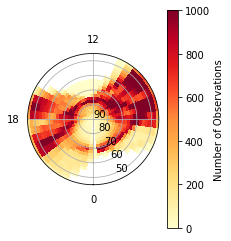

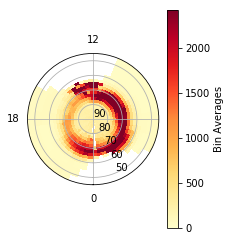

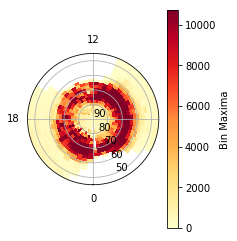

In [15]:
DMSP_FIGURE_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/figures/'
save_flag = 0

colorbar_min_density = 0
colorbar_max_density = 1000

colorbar_min_average = 0
colorbar_max_average = np.quantile(df_ML['ELE_AVG_ENERGY'].to_numpy(),.90)

colorbar_min_max = 0
colorbar_max_max = np.quantile(df_ML['ELE_AVG_ENERGY'].to_numpy(),.999)


var_for_stats = 'ELE_AVG_ENERGY'
     
grid_density,grid_average,grid_max,mlats_plot_tmp,mlts_plot_tmp = get_dmsp_coverage(df_ML,latres=2.0,ltres=0.5,verbose=0)


######## Create polar plots ########

# Observation density
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(131, polar=True)
ctf = ax.pcolormesh(mlts_plot_tmp, mlats_plot_tmp, grid_density,
                    vmin=colorbar_min_density,
                    vmax=colorbar_max_density, 
                    cmap='YlOrRd')
cbar = plt.colorbar(ctf,ax=ax)
cbar.ax.set_ylabel('Number of Observations')
cbar.set_clim(colorbar_min_density,colorbar_max_density)


# define your axis limits
ax.set_ylim([0,45])

# Set the radius labels
ax.set_yticks(np.arange(0,50,10))  # less radial ticks
ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax.set_xticklabels(('0','6','12','18'))      
# Make the labels go clockwise
# ax.set_theta_direction(-1)

ax.grid(True)
ax.set_theta_zero_location("S")


# Observation maxima
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(133, polar=True)
ctf = ax.pcolormesh(mlts_plot_tmp, mlats_plot_tmp, grid_average,
                    vmin=colorbar_min_average,
                    vmax=colorbar_max_average, 
                    cmap='YlOrRd')
cbar = plt.colorbar(ctf,ax=ax)
cbar.ax.set_ylabel('Bin Averages')
cbar.set_clim(colorbar_min_average,colorbar_max_average)


# define your axis limits
ax.set_ylim([0,45])

# Set the radius labels
ax.set_yticks(np.arange(0,50,10))  # less radial ticks
ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax.set_xticklabels(('0','6','12','18'))      
# Make the labels go clockwise
# ax.set_theta_direction(-1)

ax.grid(True)
ax.set_theta_zero_location("S")


# Observation averages
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(132, polar=True)
ctf = ax.pcolormesh(mlts_plot_tmp, mlats_plot_tmp, grid_max,
                    vmin=colorbar_min_max,
                    vmax=colorbar_max_max, 
                    cmap='YlOrRd')
cbar = plt.colorbar(ctf,ax=ax)
cbar.ax.set_ylabel('Bin Maxima')
cbar.set_clim(colorbar_min_max,colorbar_max_max)


# define your axis limits
ax.set_ylim([0,45])

# Set the radius labels
ax.set_yticks(np.arange(0,50,10))  # less radial ticks
ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax.set_xticklabels(('0','6','12','18'))      
# Make the labels go clockwise
# ax.set_theta_direction(-1)

ax.grid(True)
ax.set_theta_zero_location("S")



plt.show() 
if save_flag == 1:
    fig_filename = DMSP_FIGURE_DIR + 'obs_density_ML_DB.png'
    plt.savefig(fig_filename)

#### Construct the keras model

In [12]:
# x = k.layers.Dense(128, activation='relu')(x)
# x = k.layers.Dense(64, activation='relu')(x)
# x = k.layers.Dropout(0.5)(x)
# x = k.layers.Dense(32, activation='relu')(x)
# x = k.layers.Dense(64, activation='relu')(x)
# out = k.layers.Dense(1, activation='linear')(x)


model = k.models.Sequential()
model.add(k.layers.Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(k.layers.Dense(64, activation='relu'))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.Dense(32, activation='relu'))
model.add(k.layers.Dense(64, activation='relu'))
# model.add(k.layers.Dense(1, activation='sigmoid'))
model.add(k.layers.Dense(1, activation='linear'))

In [15]:
# From 2019 GNSS FDL team
model.compile(loss=different_exponent, optimizer = k.optimizers.Adam(1e-4),  metrics=['logcosh','mse','mae'])

# Fit the model
history = model.fit(X_train_scaled,
                    y_train, 
                    epochs=30, 
                    batch_size=128,
                    validation_data=(X_val_scaled, y_val.values), 
#                     validation_data=np.concatenate((X_val_scaled, np.reshape(y_val.values, (-1,1))),1), 
                    )





Train on 315866 samples, validate on 54110 samples
Epoch 1/30
315866/315866 [==============================] - 4s 14us/step - loss: 6923027965.1634 - logcosh: 800.0112 - mean_squared_error: 1683255.2726 - mean_absolute_error: 800.7040 - val_loss: 14924438326.3036 - val_logcosh: 1491.0657 - val_mean_squared_error: 3768193.1296 - val_mean_absolute_error: 1491.7588
Epoch 2/30
315866/315866 [==============================] - 3s 10us/step - loss: 5223597281.0190 - logcosh: 891.3637 - mean_squared_error: 1571267.0040 - mean_absolute_error: 892.0567 - val_loss: 15684373343.5588 - val_logcosh: 1405.0811 - val_mean_squared_error: 3687003.7277 - val_mean_absolute_error: 1405.7741
Epoch 3/30
315866/315866 [==============================] - 3s 10us/step - loss: 5105106283.7504 - logcosh: 875.5709 - mean_squared_error: 1550184.7021 - mean_absolute_error: 876.2636 - val_loss: 16078896925.8533 - val_logcosh: 1377.3004 - val_mean_squared_error: 3681865.6656 - val_mean_absolute_error: 1377.9934
Epoch 4

315866/315866 [==============================] - 3s 11us/step - loss: 2345482345.8669 - logcosh: 420.7362 - mean_squared_error: 746362.0403 - mean_absolute_error: 421.4206 - val_loss: 5596920214.2693 - val_logcosh: 833.8390 - val_mean_squared_error: 1685383.8197 - val_mean_absolute_error: 834.5314
Epoch 28/30
315866/315866 [==============================] - 4s 12us/step - loss: 2311811647.8501 - logcosh: 418.5076 - mean_squared_error: 740056.2166 - mean_absolute_error: 419.1931 - val_loss: 5666032197.8335 - val_logcosh: 820.2701 - val_mean_squared_error: 1664938.5673 - val_mean_absolute_error: 820.9612
Epoch 29/30
315866/315866 [==============================] - 4s 11us/step - loss: 2264065466.0467 - logcosh: 415.5894 - mean_squared_error: 728959.4410 - mean_absolute_error: 416.2753 - val_loss: 5555320331.5202 - val_logcosh: 838.3641 - val_mean_squared_error: 1675806.6946 - val_mean_absolute_error: 839.0556
Epoch 30/30
315866/315866 [==============================] - 3s 11us/step - los

dict_keys(['val_loss', 'val_logcosh', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'logcosh', 'mean_squared_error', 'mean_absolute_error'])


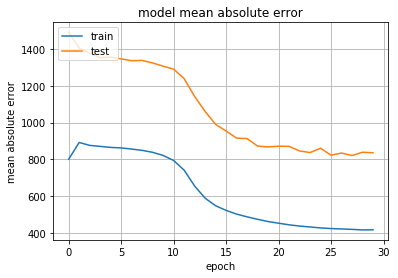

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_val = model.predict(X_val_scaled)

In [ ]:
for i in range(100):
    print('VALIDATION DATA: observed = {}, predicted = {}'.format(y_val[i],y_pred_val[i]))

In [ ]:
%matplotlib notebook
#inline 


idx = [0,len(y_val)]
ylims = [0,15]

fig = plt.figure(figsize=(10,10))

plt.subplot(111)
plt.scatter(y_val[idx[0]:idx[1]].index,
            y_val[idx[0]:idx[1]],
            c='k',
            alpha=0.8,
            label='observed')
plt.scatter(y_val[idx[0]:idx[1]].index,
            y_pred_val[idx[0]:idx[1]],
            c='g',
            alpha=0.8,
            label='predicted')
plt.xlabel('Datetimes')
plt.xlim( (min(y_val[idx[0]:idx[1]].index),max(y_val[idx[0]:idx[1]].index)) )
# plt.xlim( datetime.datetime(2010,6,26,9),datetime.datetime(2010,6,26,11) )
plt.ylabel('Total electron energy flux [eV/cm2/s/ster]')
plt.title('VALIDATION DATA')
plt.legend()
# plt.ylim([ylims[0],ylims[1]])
plt.grid(True)


In [ ]:

# ax_lims = [5,15]
# c_lims = [-5,5]
ax_lims = [0,5000]
c_lims = [-500,500]

R = np.corrcoef(y_pred.flatten(),y_test)

fig = plt.figure(figsize=(5,5))
scat = plt.scatter(y_pred.flatten(),
                   y_test,
                   c=y_pred.flatten()-y_test,
                   cmap='RdBu',
                   vmin=c_lims[0],
                   vmax=c_lims[1])
plt.xlabel('Predictions - TEST DATA')
plt.ylabel('Observations - TEST DATA')
cbar = plt.colorbar(scat)
cbar.set_label('Difference')
plt.clim(c_lims[0],c_lims[1])
plt.plot(np.array([ax_lims[0],ax_lims[1]]),np.array([ax_lims[0],ax_lims[1]]),'k','--')

plt.text(0.7*ax_lims[1],0.6*ax_lims[1],'R   = '+str(R[1,0]))
plt.text(0.7*ax_lims[1],0.65*ax_lims[1],'R^2 = '+str(metrics.r2_score(y_test,y_pred.flatten())))
plt.grid(True)
plt.xlim(ax_lims[0],ax_lims[1])
plt.ylim(ax_lims[0],ax_lims[1])
plt.gca().set_aspect('equal', adjustable='box')
# plt.axis('equal')
# fig.savefig('/Users/ryanmcgranaghan/Documents/Conductivity/dev/randomForest_validation_correlation.png')

In [ ]:

# ax_lims = [5,15]
# c_lims = [-5,5]
ax_lims = [0,5000]
c_lims = [-500,500]

R = np.corrcoef(y_pred_val.flatten(),y_val)

fig = plt.figure(figsize=(5,5))
scat = plt.scatter(y_pred_val.flatten(),
                   y_val,
                   c=y_pred_val.flatten()-y_val,
                   cmap='RdBu',
                   vmin=c_lims[0],
                   vmax=c_lims[1])
plt.xlabel('Predictions - VALIDATION DATA')
plt.ylabel('Observations - VALIDATION DATA')
cbar = plt.colorbar(scat)
cbar.set_label('Difference')
plt.clim(c_lims[0],c_lims[1])
plt.plot(np.array([ax_lims[0],ax_lims[1]]),np.array([ax_lims[0],ax_lims[1]]),'k','--')

plt.text(0.7*ax_lims[1],0.6*ax_lims[1],'R   = '+str(R[1,0]))
plt.text(0.7*ax_lims[1],0.65*ax_lims[1],'R^2 = '+str(metrics.r2_score(y_val,y_pred_val.flatten())))
plt.grid(True)
plt.xlim(ax_lims[0],ax_lims[1])
plt.ylim(ax_lims[0],ax_lims[1])
plt.gca().set_aspect('equal', adjustable='box')
# plt.axis('equal')
# fig.savefig('/Users/ryanmcgranaghan/Documents/Conductivity/dev/randomForest_validation_correlation.png')